In [66]:
from data_generation import attention_fakedata
import matplotlib.pyplot as plt

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from trainAttn_fakedata import SelfAttentionLightning
from data_generation import prepare_data

import os

In [65]:
df = attention_fakedata(5)
mask0 = df['label'] == 0
mask1 = df['label'] == 1

(100000, 6)


In [67]:
df.h

,label,f0,f1,f2,f3,f4
0,0.0,0.593162,0.091680,0.554308,0.938422,0.168033
1,0.0,-1.848946,0.240158,0.679579,0.161083,0.046975
2,0.0,0.764247,0.498487,0.496122,0.317818,0.699608
3,0.0,-1.515110,0.898559,0.488243,0.266235,0.139516
4,1.0,100.295370,0.110525,0.931582,0.219879,0.382056


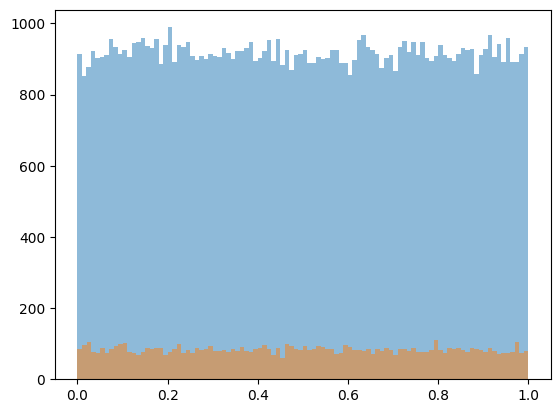

In [69]:
i = 1
f_a = df.loc[mask0, f'f{i}']
f_b = df.loc[mask1, f'f{i}']

plt.hist(f_a, bins=100, alpha=0.5)
plt.hist(f_b, bins=100, alpha=0.5);

In [5]:
# Load the data
data = {}
for f in range(2,6):
    train_dataset, val_dataset, n_features = prepare_data(f)

    # Get features and labels
    train_features = train_dataset.tensors[0]
    train_labels = train_dataset.tensors[1]

    data[f] = (train_features,train_labels)

(100000, 3)
(100000, 4)
(100000, 5)
(100000, 6)


In [6]:
# # Load your trained model - replace with your actual model path
basepath = "/media/dan/Data/outputs/ubiquitous-spork/attention_prediction/varying_feature_counts/models"
models = {}
for f in range(2,6):
    temp = []
    for i in range(10):
        model_name = f"{f}_features"
        model_path = os.path.join(basepath, str(f),  f"{model_name}~{i}" ,f"{model_name}~{model_name}~{i}~final_model.ckpt")
        model = SelfAttentionLightning.load_from_checkpoint(model_path)
        model.eval()
        temp.append(model)
    models[f] = temp


In [60]:
model = models[2][0]
train_features, train_labels = data[2]


def plot_attention_weights(model, train_features, train_labels, output_path):
    train_labels = train_labels.squeeze() 
    with torch.no_grad():
        _, attention_weights = model(train_features)

    # Convert attention weights to numpy for easier manipulation
    attention_weights = attention_weights.numpy()

    # Calculate mean attention patterns
    mean_all = attention_weights.mean(axis=0).squeeze()
    mean_0 = attention_weights[train_labels == 0].mean(axis=0).squeeze()
    mean_1 = attention_weights[train_labels == 1].mean(axis=0).squeeze()


    # Create figure with subplots
    n_features = attention_weights.shape[1]  # Should be the size of your attention matrix
    fig = plt.figure(figsize=(7, 7))

    # First row - heatmaps (1x3)
    gs = fig.add_gridspec(2, 3, height_ratios=[1, 2]) 

    # Plot heatmaps in first row
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])

    sns.heatmap(mean_all, annot=True, cbar=True, square=True, fmt='.2f', ax=ax1, cmap='hot', vmin=0, vmax=1,annot_kws={"size": 10 / np.sqrt(n_features)},)
    sns.heatmap(mean_0, annot=True, cbar=True, square=True, fmt='.2f', ax=ax2, cmap='hot', vmin=0, vmax=1,annot_kws={"size": 10 / np.sqrt(n_features)},)
    sns.heatmap(mean_1, annot=True, cbar=True, square=True, fmt='.2f', ax=ax3, cmap='hot', vmin=0, vmax=1,annot_kws={"size": 10 / np.sqrt(n_features)},)

    ax1.set_title('All Samples')
    ax2.set_title('Non-SOZ (label=0)')
    ax3.set_title('SOZ (label=1)')
    

    # Second row - grid of histograms
    gs2 = gs[1, :].subgridspec(n_features, n_features)
    for i in range(n_features):
        for j in range(n_features):
            ax = fig.add_subplot(gs2[i, j])
            # Get weights for this position
            weights_0 = attention_weights[train_labels == 0, i, j]
            weights_1 = attention_weights[train_labels == 1, i, j]
            ax.hist(weights_0, bins=25, alpha=0.5, color='b', label='0')
            ax.hist(weights_1, bins=25, alpha=0.8, color='r', label='1')
            ax.set_title(f'[{i},{j}]',fontsize=8/np.sqrt(n_features))
            if i == 0 and j == 0:  # Only show legend for first plot
                ax.legend(fontsize=8/np.sqrt(n_features))
            # Remove axis labels to make plot cleaner
            ax.grid(True)
            ax.set_xlim(0, 1)
            ax.set_xticks(np.linspace(0, 1, 11))
            ax.set_yticks([])
            ax.tick_params(axis='both', labelsize=6/np.sqrt(n_features),rotation=-45)

    plt.suptitle(os.path.basename(output_path).split(".")[0])
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)  # Add additional spacing

    plt.savefig(output_path, dpi=300)
    plt.close()


In [61]:
output_path_base = "/media/dan/Data/outputs/ubiquitous-spork/attention_prediction/varying_feature_counts/plots"
for f in range(2,6):
    for i in range(10):
        output_path = os.path.join(output_path_base, f"{f}_features~{i}.png")
        plot_attention_weights(models[f][i], data[f][0], data[f][1], output_path)


In [75]:
model = models[5][4]
train_features, train_labels = data[2]

# train_labels = train_labels.squeeze() 
# with torch.no_grad():
#     _, attention_weights = model(train_features)

In [78]:
model.attn.out_proj.weight.data

tensor([[-0.0417]])

In [79]:
model.ln.weight.data

tensor([2.0145, 1.1424, 0.8870, 1.6815, 1.3850])

In [77]:
model.fc1.weight.data

tensor([[-0.7307,  1.0165,  0.1907,  0.6665,  0.8570]])

In [62]:
import tensorboard as tb

In [63]:
experiment_id = "c1KCv3X3QvGwaXfgX1c4tg"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()

AttributeError: module 'tensorboard' has no attribute 'data'